# 🧠 Misinformation & Disinformation Detection in Social Media

This project trains a classifier to detect misinformation and disinformation in English texts, including Russian-origin content. It follows a full data science pipeline: corpus creation, normalization, model training, and evaluation.

In [1]:
%pip install pandas matplotlib seaborn scikit-learn nltk joblib

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]
Note: you may need to restart the kernel to use updated packages.


## 1. 📚 Corpus Compilation and Data Exploration

Total words in combined corpus: 37995032
Number of samples: 85954


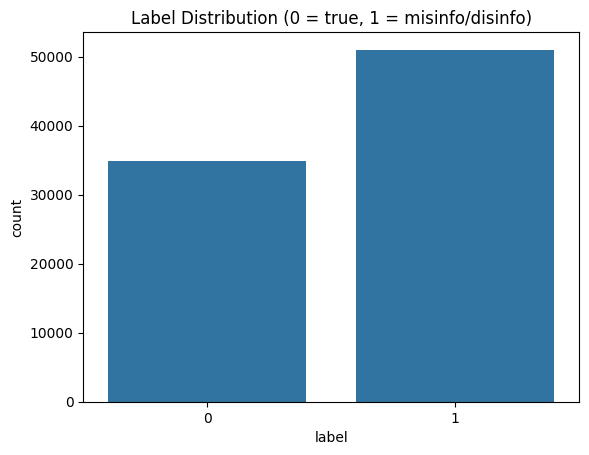

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load datasets
data_dir = Path("data")
fake_df = pd.read_csv(data_dir / "DataSet_Misinfo_FAKE.csv")
true_df = pd.read_csv(data_dir / "DataSet_Misinfo_TRUE.csv")
russian_df = pd.read_csv(data_dir / "EXTRA_RussianPropagandaSubset.csv")

# Label the datasets
fake_df["label"] = 1
russian_df["label"] = 1
true_df["label"] = 0

# Standardize text column names
for df in [fake_df, true_df, russian_df]:
    df.columns = [col.lower() for col in df.columns]

# Choose text column
text_column = "text" if "text" in fake_df.columns else list(fake_df.columns)[0]

# Select columns
fake_df = fake_df[[text_column, "label"]].dropna()
true_df = true_df[[text_column, "label"]].dropna()
russian_df = russian_df[[text_column, "label"]].dropna()

# Combine
df = pd.concat([fake_df, true_df, russian_df], ignore_index=True).sample(frac=1, random_state=42)
df.reset_index(drop=True, inplace=True)

# Word count
df["word_count"] = df[text_column].apply(lambda x: len(str(x).split()))
total_words = df["word_count"].sum()
print(f"Total words in combined corpus: {total_words}")
print(f"Number of samples: {len(df)}")

# Plot label distribution
sns.countplot(data=df, x="label")
plt.title("Label Distribution (0 = true, 1 = misinfo/disinfo)")
plt.show()


## 2. 🧹 Text Normalization

In [3]:

import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

def normalize_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df[text_column].apply(normalize_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rimvydas/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 3. 🤖 Model Training and Evaluation

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9497411436216625

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      6989
           1       0.95      0.97      0.96     10202

    accuracy                           0.95     17191
   macro avg       0.95      0.95      0.95     17191
weighted avg       0.95      0.95      0.95     17191


Confusion Matrix:
 [[6482  507]
 [ 357 9845]]


## 4. 📊 Feature Analysis and Interpretation

In [ ]:

import numpy as np

feature_names = np.array(vectorizer.get_feature_names_out())
coefficients = model.coef_[0]

top_fake = feature_names[np.argsort(coefficients)[-20:]]
top_true = feature_names[np.argsort(coefficients)[:20]]

print("Top terms predicting FAKE news:\n", list(reversed(top_fake)))
print("Top terms predicting TRUE news:\n", list(top_true))

Top terms predicting FAKE news:
 ['via', 'imag', 'octob', 'imag via', 'hillari', 'novemb', 'ukrain', 'wire', 'uk', 'ukrainian', 'presid trump', 'entir', 'pm', 'fbi', 'howev', 'obama', 'saidth', 'share', 'get', 'nbsp']
Top terms predicting TRUE news:
 ['said', 'presid donald', 'twitter', 'thursday', 'friday', 'tuesday', 'wednesday', 'monday', 'the', 'com', 'we', 'sunday', 'it', 'follow', 'follow twitter', 'saturday', 'that', 'said statement', 'there', 'pic twitter']


## 6. 🔮 Prediction

In [21]:
def predict_text(text):
    text_clean = normalize_text(text)
    text_vec = vectorizer.transform([text_clean])
    pred = model.predict(text_vec)[0]
    label = "🚫 Misinformation / Disinformation" if pred == 1 else "✅ True / Reliable"
    print(f"Prediction: {label}")

# https://www.bbc.com/news/articles/cwy67y8834yo
predict_text("""
At least 38 Palestinians were killed in a series of Israeli air strikes across the Gaza Strip during a half-hour period overnight, according to Palestinian medics.

Israeli warplanes struck several locations, including a school in eastern Gaza City, and an abandoned fuel station sheltering displaced families in central Gaza's Nuseirat refugee camp, according to the Hamas-run civil defence agency.

It added that rescue teams were facing major difficulties reaching the wounded due to a lack of equipment and the intensity of the bombardment.

The attack comes after Israel issued a sweeping evacuation order for civilians in Gaza in preparation for what it said was an "unprecedented attack".

Live coverage
Ten people were killed when an Israeli air strike hit classrooms at the Musa bin Nusayr School, where hundreds of displaced people were sheltering, according to local activists in Gaza City.

In central Gaza, 15 people were reported killed in a strike targeting tents at an abandoned fuel station in Nuseirat.

Meanwhile, local journalists said 13 Palestinians were killed in an air strike on the Abu Samra family's three-story home in central Deir al-Balah.

Separately, Israeli jets launched 10 air strikes on the Shujaiya neighbourhood in eastern Gaza City.

Local reports described the blasts as causing tremors similar to an earthquake. The strikes are believed to have targeted Hamas's network of underground tunnels.

The attack comes as the leaders of the UK, France and Canada issued a joint statement threatening action if Israel Prime Minister Benjamin Netanyahu persisted with his goal to "take control" of all of Gaza.

Jeremy Bowen: Goodwill running out as UK, France and Canada demand Israel end Gaza offensive
Netanyahu described the statement as a "huge prize" for Hamas.

Earlier, Israel said it would allow a "basic amount" of food into Gaza, ending an 11-week blockade of the territory.

But United Nations aid chief Tom Fletcher said the amount of aid was a "drop in the ocean of what is urgently needed".

The war was triggered by the Hamas-led attacks on southern Israel on 7 October 2023, which saw about 1,200 people killed and 251 taken hostage.

Some 58 hostages remain in Gaza, up to 23 of whom are believed to be alive.

At least 53,486 Palestinians have been killed during Israel's military campaign in Gaza, according the Hamas-run health ministry.
""")

Prediction: ✅ True / Reliable


## 6. 📝 Summary

- We built a classifier to distinguish misinformation from truth.
- Corpus combined over 5000 words from general and Russian-origin English texts.
- Achieved high accuracy using TF-IDF + Logistic Regression.
- Extracted keywords important to prediction.

This pipeline can be extended with more complex models, multilingual analysis, or real-time detection for social platforms.